# Palette Matching

In [43]:
from phomo import Pool, Master, Mosaic
from phomo.utils import rainbow_of_squares

In [44]:
import matplotlib.pyplot as plt
import numpy as np

In [45]:
from pathlib import Path

We are once again using the `UTKFaces` dataset. As you would expect, is contains a lot of flesh tone colours.

In [46]:
pool = Pool.from_dir("faces/", tile_size=(10, 10))

Loading tiles: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 9780/9780 [00:04<00:00, 2355.93it/s]


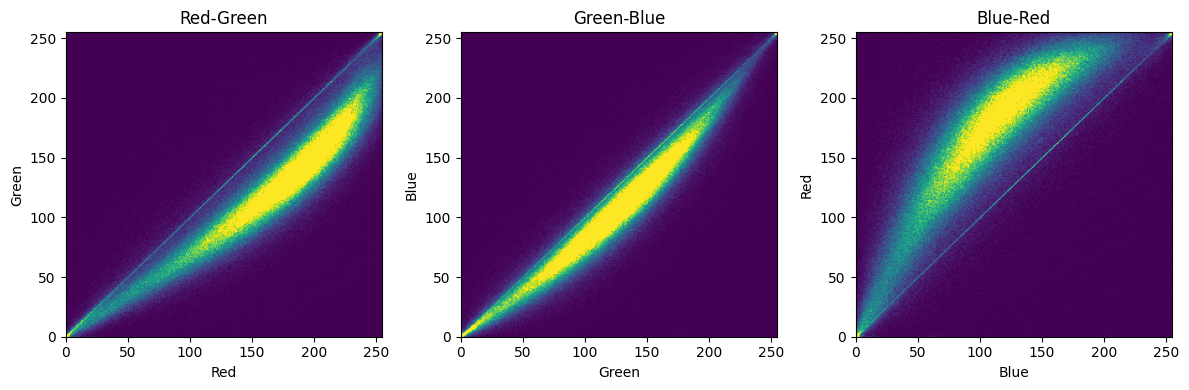

In [47]:
pool.plot();

As a master image let's use `Stary Night` which mostly has blues/greens.

Due to the big difference in colour distribution between our master image and the tile images, we can't expect to get a great photo mosaic straight away.

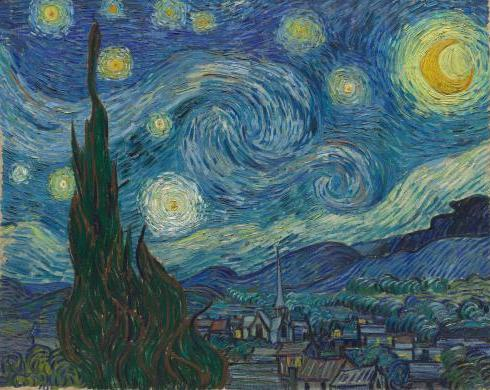

In [72]:
master = Master.from_file("master.jpg")
master.img

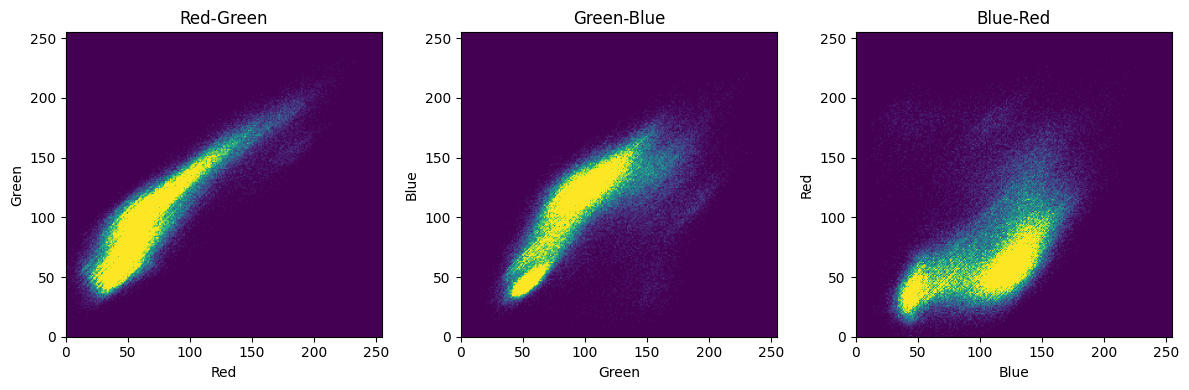

In [73]:
master.plot();

In [50]:
def build_mosaic(master, pool):
    mosaic = Mosaic(master, pool)
    mosaic_img = mosaic.build(mosaic.d_matrix_cuda())
    distance = np.linalg.norm(mosaic.master.array.astype(float) - np.array(mosaic_img).astype(float))
    num_pixels = np.prod(mosaic.master.array.shape)
    loss =  distance / num_pixels
    print(f"Loss: {loss}")
    return mosaic_img

Let's see what the photo mosaic looks like:

Building mosaic: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1911/1911 [00:00<00:00, 346728.16it/s]

Loss: 0.06740223794924285


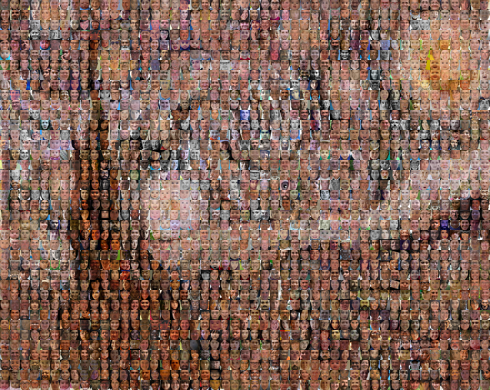

In [51]:
build_mosaic(master, pool)

Yeah not great, clearly the flesh tones don't really match well with the blue/green `Stary Night`.

We have a few ways to get around this.

## Equalizing the colour distributions

We can spread the colour distributions of both the `Master` and the `Pool` to cover the full RGB space.

This will modify the appearance of the master and pool images but lead to better mosaics.

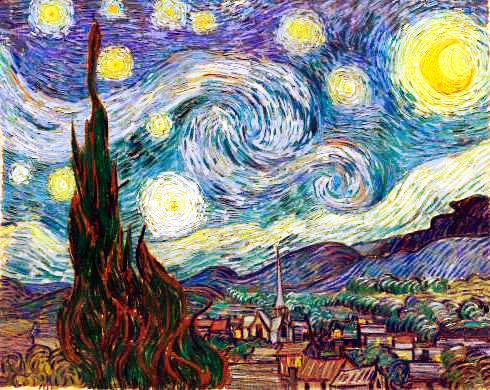

In [60]:
master_eq = master.equalize()
pool_eq = pool.equalize()
master_eq.img

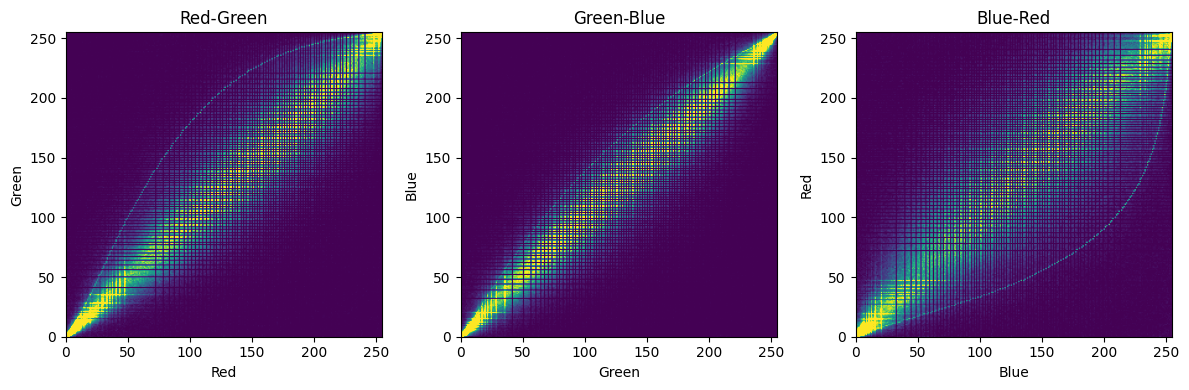

In [57]:
pool_eq.plot();

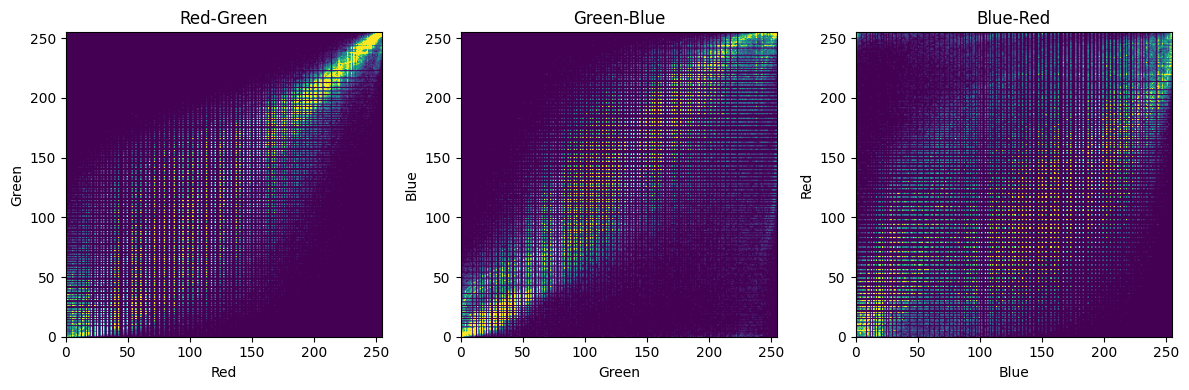

In [59]:
master_eq.plot();

Building mosaic: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1911/1911 [00:00<00:00, 349647.31it/s]

Loss: 0.06615275570074403


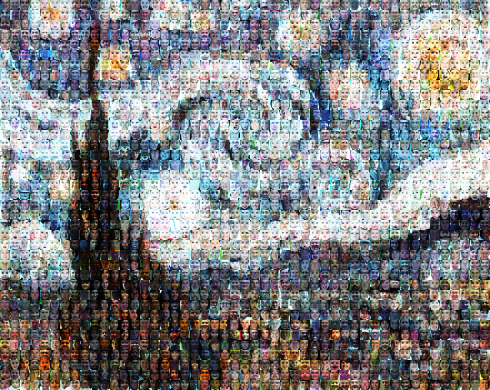

In [61]:
build_mosaic(master_eq, pool_eq)

This is already much better, but, seeing as we modified the colour distribution of both the `Master` and the `Pool`, neither the tile images or the master image are representative of the original images.

This is made obvious, by the eerily white faces which make up the clouds of the night sky.

## Palette transfer

### `Master` -> `Pool`
Another approach is to cast the `Master`'s colour distribution to match the tile pool.

This will modify the master image to be closer to the colours in the tile images while leaving the tile images unchanged.

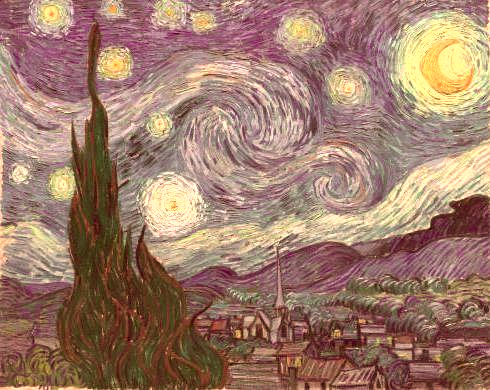

In [74]:
matched_master = master.match(pool)
matched_master.img

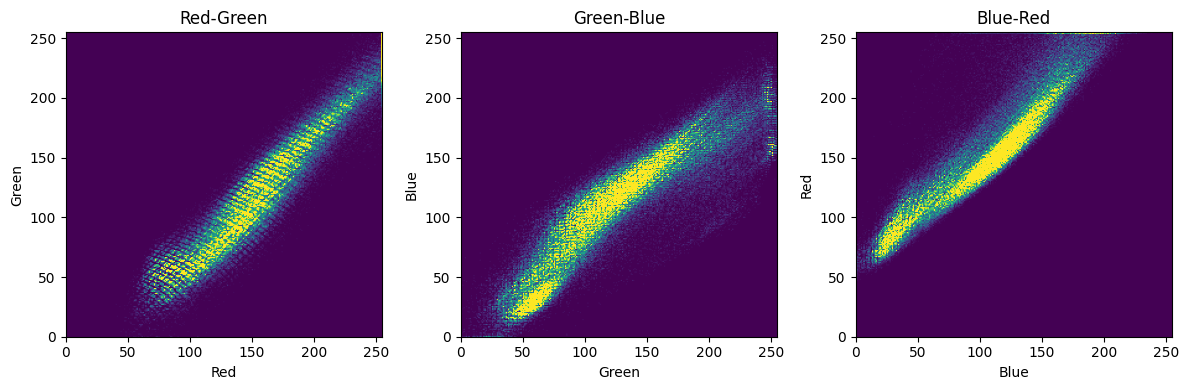

In [75]:
matched_master.plot();

Building mosaic: 100%|████████████████████████████████████████████████████████████████████████████████| 1911/1911 [00:00<00:00, 391755.37it/s]

Loss: 0.04494942425162315


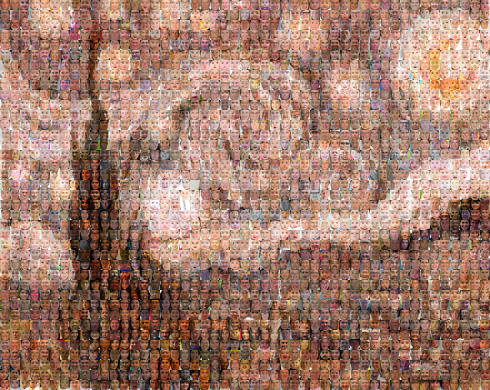

In [76]:
build_mosaic(matched_master, pool)

Ok so we get a nicer flesh toned `Stary Night`, where the tile images are the unmodified images we provided.

### `Pool` -> `Master`

We can also do the opposite, and modify the tile image pool to better match the master image.

In [77]:
pool_matched = pool.match(master)

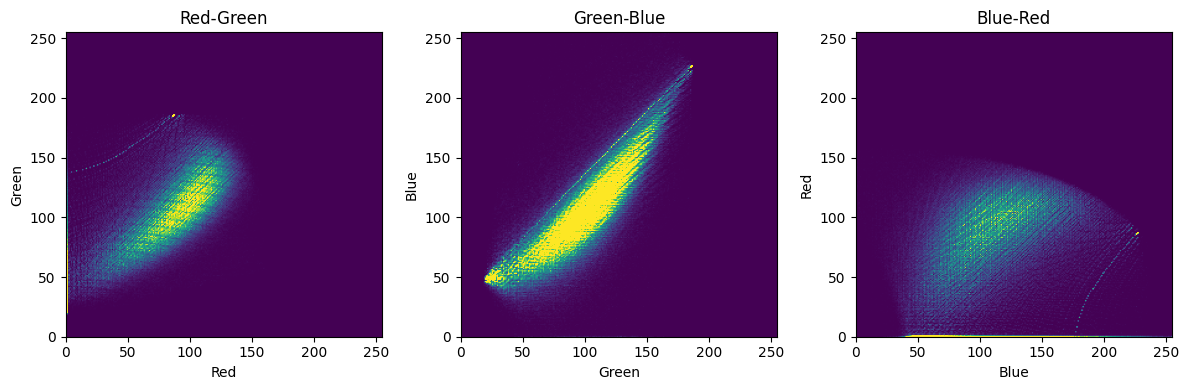

In [78]:
pool_matched.plot();

Building mosaic: 100%|████████████████████████████████████████████████████████████████████████████████| 1911/1911 [00:00<00:00, 395915.78it/s]

Loss: 0.03631232331544263


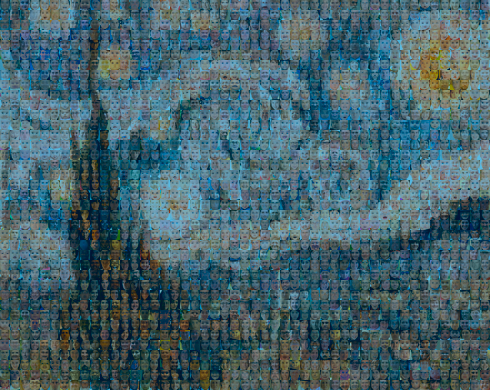

In [79]:
build_mosaic(master, pool_matched)

This is the mosaic closest to the original `Stary Night`, but the tile images have been severly shifted towards the blue/green.